
# Setup

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/CaptionGeneration

/content/drive/My Drive/Colab Notebooks/CaptionGeneration


In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/CaptionGeneration'

In [ ]:
%mkdir dataset

In [ ]:
%cd dataset

/content/drive/My Drive/Colab Notebooks/CaptionGeneration/dataset


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/CaptionGeneration/dataset"

In [ ]:
!kaggle datasets download -d watts2/glove6b50dtxt

 86% 58.0M/67.7M [00:01<00:00, 34.4MB/s]
100% 67.7M/67.7M [00:01<00:00, 48.4MB/s]


In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.12G/2.13G [00:41<00:00, 76.0MB/s]
100% 2.13G/2.13G [00:41<00:00, 54.8MB/s]


In [ ]:
!touch kaggle.json

In [ ]:
!unzip glove6b50dtxt.zip -d saved_data/

Archive:  glove6b50dtxt.zip
  inflating: saved_data/glove.6B.50d.txt  


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (713 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -L 3

.
├── flickr8k.zip
├── flickr_data
│   └── Flickr_Data
│       ├── flickr8ktextfiles
│       ├── Flickr_TextData
│       └── Images
├── Flickr_Data
│   └── Flickr_Data
│       ├── flickr8ktextfiles
│       ├── Flickr_TextData
│       └── Images
├── kaggle.json
├── model_weights.h5
└── train_encoded_images.p

10 directories, 4 files


# Data Preparation

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
import collections # for counter
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
import pickle

Using TensorFlow backend.


In [ ]:
ROOT = "/content/drive/My Drive/Colab Notebooks/CaptionGeneration/"
IMG_DIR = 'dataset/flickr_data/Flickr_Data/Images/'
example_image = '997722733_0cb5439472.jpg'
exp_id = "1001773457_577c3a7d70"

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/CaptionGeneration/dataset/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt') as f:
  captions = f.read()

In [ ]:
type(captions)

str

In [ ]:
captions[:500]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7'

In [ ]:
captions = captions.split('\n')

In [ ]:
type(captions)

list

In [ ]:
captions[1]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [ ]:
# dict - imagesId --> [list of captions]

captions_dict = {}
for c in captions[:-1]:
  # print(c)
  id, cap = c.split('\t')
  # print(id)
  # print(cap)
  image_name = id.split('.')[0]
  
  # put captions in their corespoing imgage mapping
  if captions_dict.get(image_name) is None:     
    # put new img id in dict
    captions_dict[image_name] = []
  
  # append list of caption 
  captions_dict[image_name].append(cap)


In [ ]:
len(captions_dict)

8092

In [ ]:
captions_dict['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
captions_dict.items()

Output hidden; open in https://colab.research.google.com to view.

Text cleaning

In [ ]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/CaptionGeneration/dataset/flickr_data/Flickr_Data/Images/1001773457_577c3a7d70.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

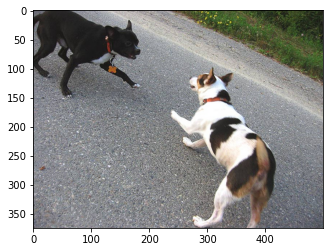

In [ ]:
plt.imshow(img)

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [word for word in text if len(word) > 1]
  text =  ' '.join(text)
  return text

In [ ]:
clean_text("Hello, How are you?")

'hello how are you'

In [ ]:
for id,caps in captions_dict.items():
  for i in range(len(caps)):
    caps[i] = clean_text(caps[i]) 

In [ ]:
captions_dict['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
# save cleaned version of captions dictionary
with open('saved_data/cleaned_captions_data.txt', 'w') as f:
  f.write(str(captions_dict))

In [ ]:
# read saved cleaned file
cleaned_captions = None
with open(ROOT + 'saved_data/cleaned_captions_data.txt') as f:
  cleaned_captions = f.read()   # string

In [ ]:
type(cleaned_captions)

str

In [ ]:
# convert to python dict
cleaned_captions = cleaned_captions.replace("'", "\"")

In [ ]:
cleaned_captions = json.loads(cleaned_captions)

In [ ]:
type(cleaned_captions)

dict

In [ ]:
cleaned_captions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
# creating vocabulary

vocab = set()
for key in cleaned_captions.keys():
  [vocab.update( sentence.split()) for sentence in cleaned_captions[key] ]

print(len(vocab))

8424


In [ ]:
# total number of words in dataset

total_words = []

for key in cleaned_captions.keys():
  [total_words.append(i) for caps in cleaned_captions[key] for i in caps.split()]

print(len(total_words))

373837


In [ ]:
# remove infrequent words

counter = collections.Counter(total_words)
freq_count = dict(counter)
print(freq_count)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [ ]:
fc_sorted = sorted(freq_count.items(), reverse=True, key= lambda x : x[1])
threshold = 10
fc_sorted = [x for x in fc_sorted if x[1] > threshold]
unique_words = [word[0] for word in fc_sorted]
print(len(unique_words))

1845


In [ ]:
unique_words

## Loading Training and Testing Data

In [ ]:
train_file =  ROOT + 'dataset/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_file = ROOT + 'dataset/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

In [ ]:
# train_file content name of images in one line 
train_file_data = ""
with open(train_file, 'r') as f:
  train_file_data = f.read()

In [ ]:
train = [row.split('.')[0]  for row in train_file_data.split('\n')[:-1]]

In [ ]:
len(train)

6000

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# load test file

test_file_data = ""
with open(test_file, 'r') as f:
  test_file_data = f.read()

In [ ]:
test = [row.split('.')[0]  for row in test_file_data.split('\n')[:-1]]

In [ ]:
len(test)


1000

In [ ]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

Preparing data for training 

```

*   add start token and end token


```



In [ ]:
train_dict = {}

for img_id in train:
  train_dict[img_id] = []
  for cap in cleaned_captions[img_id]:
    cap_to_append = "startseq " + cap + " endseq"
    train_dict[img_id].append(cap_to_append)

print(train_dict[exp_id])

['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


Using transfer learning to extract features from images

In [ ]:
# pretrained model - resnet-50 trained on imagenet

model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
# model.summary()

102858752/102853048 [==============================] - 3s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)
# model_new.summary()

In [ ]:
def preprocess_img(img):
  img = load_img(img, target_size=(224, 224, 3))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = preprocess_input(img)     # minus the channel mean whcih produces negative pixel values
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


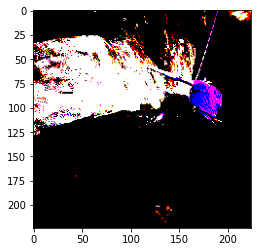

In [ ]:
img = preprocess_img(ROOT + IMG_DIR + example_image)
plt.imshow(img[0])
plt.show()

In [ ]:
# give encoded output from resnet

def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)   # resnet out which will be fed to the capture gen model
  # print(feature_vector.shape)
  feature_vector = feature_vector.reshape((2048, ))   # reshape((-1, ))
  return feature_vector

In [ ]:
fv = encode_image(ROOT+IMG_DIR+example_image)
fv.shape

KeyboardInterrupt: ignored

In [ ]:
# encode all images and save these encodings

encoding_train = {}   # img_id --> feature vector from resnet
for ix, img_id in enumerate(train):
  img = ROOT + IMG_DIR + img_id + '.jpg'
  encoding_train[img_id] = encode_image(img)

  if ix%100 == 0:
    print("Enncoding... Timestamp: ", ix)


Enncoding... Timestamp:  0
Enncoding... Timestamp:  100
Enncoding... Timestamp:  200
Enncoding... Timestamp:  300
Enncoding... Timestamp:  400
Enncoding... Timestamp:  500
Enncoding... Timestamp:  600
Enncoding... Timestamp:  700
Enncoding... Timestamp:  800
Enncoding... Timestamp:  900
Enncoding... Timestamp:  1000
Enncoding... Timestamp:  1100
Enncoding... Timestamp:  1200
Enncoding... Timestamp:  1300
Enncoding... Timestamp:  1400
Enncoding... Timestamp:  1500
Enncoding... Timestamp:  1600
Enncoding... Timestamp:  1700
Enncoding... Timestamp:  1800
Enncoding... Timestamp:  1900
Enncoding... Timestamp:  2000
Enncoding... Timestamp:  2100
Enncoding... Timestamp:  2200
Enncoding... Timestamp:  2300
Enncoding... Timestamp:  2400
Enncoding... Timestamp:  2500
Enncoding... Timestamp:  2600
Enncoding... Timestamp:  2700
Enncoding... Timestamp:  2800
Enncoding... Timestamp:  2900
Enncoding... Timestamp:  3000
Enncoding... Timestamp:  3100
Enncoding... Timestamp:  3200
Enncoding... Timestamp

In [ ]:
# store above encoding in file

with open(ROOT+"saved_data/" + "encoded_trained_features.pkl", "wb") as f:
  pickle.dump(encoding_train, f)

In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/CaptionGeneration'

In [ ]:
encoding_test = {}   # img_id --> feature vector from resnet
for ix, img_id in enumerate(test):
  img = ROOT + IMG_DIR + img_id + '.jpg'
  encoding_test[img_id] = encode_image(img)

  if ix%100 == 0:
    print("Enncoding... Timestamp: ", ix)

Enncoding... Timestamp:  0
Enncoding... Timestamp:  100
Enncoding... Timestamp:  200
Enncoding... Timestamp:  300
Enncoding... Timestamp:  400
Enncoding... Timestamp:  500
Enncoding... Timestamp:  600
Enncoding... Timestamp:  700
Enncoding... Timestamp:  800
Enncoding... Timestamp:  900


In [ ]:
# store above encoding in file

with open(ROOT+"saved_data/" + "encoded_test_features.pkl", "wb") as f:
  pickle.dump(encoding_test, f)

In [ ]:
with open(ROOT+"saved_data/" + "encoded_trained_features.pkl", 'rb') as f:
  encoding_train = pickle.load(f)

In [ ]:
with open(ROOT+"saved_data/" + "encoded_test_features.pkl", 'rb') as f:
  encoding_test = pickle.load(f)

## Preprocessing for Captions

In [ ]:
# text --> features (numbers)

word2idx = {}
idx2word = {}

for idx,word in enumerate(unique_words):
  word2idx[word] = idx+1
  idx2word[idx+1] = word 

print(len(word2idx))
print(len(idx2word))

1845
1845


In [ ]:
# add start seq and end seq at the end

word2idx['startseq'] = 1846
word2idx['endseq'] = 1847

idx2word[1846] = 'startseq'
idx2word[1847] = 'endseq'

vocab_words = unique_words
vocab_size = len(word2idx) + 1  # +1 for index 0
print(vocab_size) 

1848


In [ ]:
maxlen = 0
for key in train_dict.keys():
  for cap in train_dict[key]:
    maxlen = max(maxlen, len(cap.split()))
print(maxlen)

35


In [ ]:
vocab_size

1848

In [ ]:
word2idx['startseq']

1846

In [ ]:
idx2word[8]

'man'

## Data Generator/Loader

In [ ]:
def data_generator(train_dict, encoding_train, w2i, maxlen, batchsize):
  X1, X2, Y = [], [], []

  n = 0   
  while True:
    for key,caps in train_dict.items():
      n += 1
      img = encoding_train[key]

      for cap in caps:
       
        seq_of_wordidx = [w2i[word] for word in cap.split() if word in w2i]
        
        for i in range(len(seq_of_wordidx)):
         
          xi = seq_of_wordidx[0: i]
          yi = seq_of_wordidx[i]
         
          xi_padded = pad_sequences([xi], maxlen = maxlen, value = 0, padding = 'post')[0]
          yi_1_hot_enc = to_categorical([yi], num_classes = vocab_size)[0]
         
          X1.append(img)
          X2.append(xi_padded)
          Y.append(yi_1_hot_enc)
      
      if n == batchsize:
        yield [[np.array(X1), np.array(X2)] , np.array(Y)]
        X1,X2,Y = [],[],[]
        n = 0

## Word embedding

In [ ]:
glove = open('/content/drive/My Drive/Colab Notebooks/CaptionGeneration/saved_data/glove.6B.50d.txt') 

In [ ]:
emb_idx = {}

for line in glove:
  values = line.split()
  word = values[0]
  word_emb = np.asarray(values[1:], dtype='float')
  emb_idx[word] = word_emb

In [ ]:
glove.close()

In [ ]:
emb_idx['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
def get_embedding_matrix():
  emb_dims = 50
  matrix = np.zeros((vocab_size, emb_dims))

  for word,idx in word2idx.items():
    emb_vector = emb_idx.get(word)
    if emb_vector is not None:
      matrix[idx] = emb_vector
    
  return matrix


In [ ]:
emb_mat = get_embedding_matrix()
emb_mat.shape

(1848, 50)

## Model Architecture

In [ ]:
# image 
input_img_features = Input(shape = (2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
# captions
inp_captions = Input(shape=(maxlen, ))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(inp_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)    # 256 - output size

In [ ]:
# decoder

decoder1 = add([inp_img2, inp_cap3])  # add 256dim and 256 dims vectors
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

In [ ]:
# combined model
model = Model(inputs=[input_img_features,inp_captions], outputs= output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# initialize embedding layer

model.layers[2].set_weights([emb_mat])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Model Training



In [ ]:
epoch = 10
batchsize = 3
steps = len(train_dict) // batchsize

In [ ]:
for i in range(epoch):
  generator = data_generator(train_dict, encoding_train, word2idx, maxlen, batchsize)
  model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
  model.save(ROOT + 'saved_data/modelv2_ep' + str(i+1) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 195s 98ms/step - loss: 3.9061
Epoch 1/1
2000/2000 [==============================] - 196s 98ms/step - loss: 3.2871
Epoch 1/1
2000/2000 [==============================] - 197s 98ms/step - loss: 3.0518
Epoch 1/1
2000/2000 [==============================] - 194s 97ms/step - loss: 2.9054
Epoch 1/1
2000/2000 [==============================] - 195s 98ms/step - loss: 2.8026
Epoch 1/1
2000/2000 [==============================] - 193s 97ms/step - loss: 2.7233
Epoch 1/1
2000/2000 [==============================] - 195s 98ms/step - loss: 2.6621
Epoch 1/1
2000/2000 [==============================] - 197s 99ms/step - loss: 2.6126
Epoch 1/1
2000/2000 [==============================] - 196s 98ms/step - loss: 2.5707
Epoch 1/1
2000/2000 [==============================] - 196s 98ms/step - loss: 2.5355


## Prediction

In [ ]:
model = load_model(ROOT + "saved_data/modelv2_ep10.h5")

In [ ]:
def predict_caption(img):
  inp_text = "startseq"

  for i in range(maxlen):
    seq = [word2idx[w] for w in inp_text.split() if w in word2idx]
    # print("b4 pad: ", seq)
    seq = pad_sequences([seq], maxlen=maxlen, padding='post')
    # print(seq)

    ypred = model.predict([img, seq])
    ypred = ypred.argmax()    # always take word with max prob - Greedy Sampling
    
    word = idx2word[ypred]
    inp_text += ' ' + word
    # print(inp_text)

    if word == 'endseq':
      break
    
  final_caption = inp_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  # print("fc: ", final_caption)
  return final_caption

In [ ]:
# pick random imgs 

for i in range(20):
  idx = np.random.randint(0,1000)
  all_imgs = list(encoding_test.keys())
  img_name = all_imgs[idx]
  img_feature = encoding_test[img_name].reshape((1,2048))   # batch * 2048

  i = plt.imread(IMG_DIR + img_name + '.jpg')
  plt.imshow(i)
  plt.axis('off')
  plt.show()
  caption = predict_caption(img_feature)
  print(caption)


Output hidden; open in https://colab.research.google.com to view.

# Git

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/CaptionGeneration


In [1]:
!git init

Initialized empty Git repository in /content/.git/


In [2]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.config/
	drive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git remote add origin "https://github.com/abbbsss/Image-Caption-Generator.git"

In [ ]:
!git remote -v

origin	https://github.com/abbbsss/Image-Caption-Generator.git (fetch)
origin	https://github.com/abbbsss/Image-Caption-Generator.git (push)


In [ ]:
!git add saved_data/ caption.ipynb

In [ ]:
!git commit -m "initial commit"
!git status

[master (root-commit) dd6a308] initial commit
 4 files changed, 2 insertions(+)
 create mode 100644 caption.ipynb
 create mode 100644 saved_data/cleaned_captions_data.txt
 create mode 100644 saved_data/encoded_test_features.pkl
 create mode 100644 saved_data/encoded_trained_features.pkl
On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   caption.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	dataset/

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git push origin master

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!git config --global user.email "bbsahmad@gmail.com"

In [ ]:
!git config --global user.name "abbbsss"

In [ ]:
%ls

id_rsa  known_hosts


In [ ]:
!mkdir -p '/content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh'


In [ ]:
!ssh-keyscan -t rsa github.com >> '/content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/known_hosts'

# github.com:22 SSH-2.0-babeld-5a455904


In [ ]:
!ssh-keygen -t rsa -C "bbsahmad@gmail.com"

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): /content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/id_rsa
/content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/id_rsa already exists.
Overwrite (y/n)? y
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/id_rsa.
Your public key has been saved in /content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:ID4SQqIofg8zzEWh4zyJ4EgkUviYyzf95IdtfcEkkDg bbsahmad@gmail.com
The key's randomart image is:
+---[RSA 2048]----+
|+=.  o. . .      |
|X   o  E o       |
|*=.o... . .      |
|X.Bo+. .   . .   |
|o=.%+   S   +    |
|...+*o .     o   |
|  . ..+ o .   .  |
|       + + . .   |
|        o   .    |
+----[SHA256]-----+


In [ ]:
!cat /content/drive/My Drive/Colab Notebooks/CaptionGeneration/.git/.ssh/id_rsa.pub

cat: /content/drive/My: No such file or directory
cat: Drive/Colab: No such file or directory
cat: Notebooks/CaptionGeneration/.git/.ssh/id_rsa.pub: No such file or directory


In [ ]:
%cd ..

/content/drive/My Drive/Colab Notebooks/CaptionGeneration


In [ ]:
!git push origin master

git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!rm -rf .git